# Azure Quantum Demo

In this notebook we will go through the process of running quantum experiments on real quantum hardware, made available through Azure Quantum.


## Prerequisites

Uncomment the below line(s) and run the cell to install any library requirements.

Using IBMQ from qiskit results in a DeprecationWarning. I tried using the new package, called qiskit_ibm_provider, but the API is for me very slow. So using the deprecated module will have to do for now. After all, its just a warning...

You need to get your Azure Quantum resource_id from your Quantum Workspace on Azure. 

You need to get your Nasdaq Data Link API token from [here](https://data.nasdaq.com/account/profile).


In [1]:
# !python3 -m pip install qiskit_ibm_provider
# !python3 -m pip install qiskit
# !python3 -m pip install matplotlib
# !python3 -m pip install qiskit[finance]
# !python3 -m pip install 


## Module imports


In [8]:
from qiskit import Aer, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map
import matplotlib.pyplot as plt
import numpy as np
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.converters import QuadraticProgramToQubo, LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import QuantumInstance
from qiskit.providers.jobstatus import JobStatus
from datetime import datetime
from azure.quantum.qiskit import AzureQuantumProvider

import warnings
warnings.filterwarnings(
    'ignore',
    category=DeprecationWarning,
)

provider = AzureQuantumProvider(
    resource_id = "<your-resource_id>",
    location = 'northeurope',
)


In [9]:
# Define some helper functions

def print_backends(provider):
    """ Print all available backends for given provider. """
    for backend in provider.backends():
        print('\n' + ' '.join([f'{k}: {v}' for k, v in backend.status().to_dict().items()]))


In [10]:
n_qubits = 5

print_backends(provider)



backend_name: ionq.qpu backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: ionq.qpu.aria-1 backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: ionq.simulator backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: microsoft.estimator backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: quantinuum.hqs-lt-s1 backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: quantinuum.hqs-lt-s1-apival backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: quantinuum.hqs-lt-s2 backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: quantinuum.hqs-lt-s2-apival backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: quantinuum.hqs-lt-s1-sim backend_version: 1 operational: True pending_jobs: 0 status_msg: 

backend_name: quantinuum.hqs-lt-s2-sim backend_version: 1 operational: True pending_job

In [33]:
# Pick your backend here
backend = provider.get_backend('quantinuum.qpu.h1-1')
# display(plot_gate_map(backend, plot_directed=True))


In [34]:
# Setup connection to Nasdaq Data Link, insert your token below.
NASDAQ_TOKEN = '<your-API-token>'
stocks = ['GOOG', 'MSFT', 'AAPL', 'AMZN', 'NFLX']

try:
    wiki = WikipediaDataProvider(
        token=NASDAQ_TOKEN,
        tickers=stocks,
        start=datetime(2016, 1, 1),
        end=datetime(2017, 1, 1),
    )
    wiki.run()
except QiskitFinanceError as err:
    print('Error retrieving the data, ', err)
    

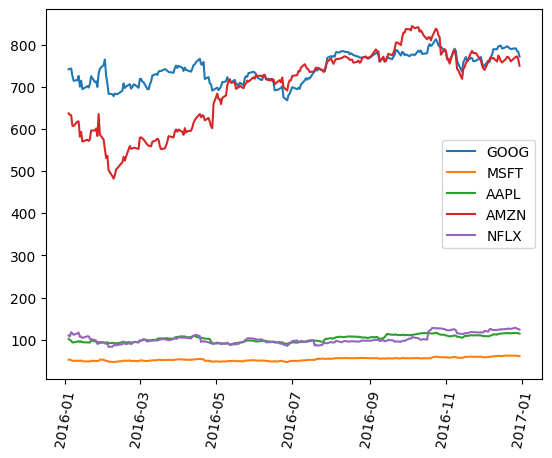

In [35]:
# Could be interesting to see and take a look at the stock price
# evolution to verify that the correct tickers have been fetched.

if wiki._data:
    for i, s in enumerate(stocks):
        plt.plot(wiki._data[i], label=s)
    plt.legend()
    plt.xticks(rotation=80)
    plt.show()
    

In [36]:
num_assets = len(stocks)
assert num_assets == n_qubits


seed = 123 # any number, to maintain reproducability of experiments

q = 0.5
B = num_assets // 2
P = num_assets

mu = wiki.get_period_return_mean_vector()
sigma = wiki.get_period_return_covariance_matrix()

problem = PortfolioOptimization(
    expected_returns=mu,
    covariances=sigma,
    risk_factor=q,
    budget=B
)

quadratic_program = problem.to_quadratic_program()
display(quadratic_program)

<QuadraticProgram: minimize 7.851184752568564e-05*x_0^2 + 0.000125377365118773..., 5 variables, 1 constraints, 'Portfolio optimization'>

## Solving portfolio optimization classically...

In [37]:
exact = NumPyMinimumEigensolver()
exact_solver = MinimumEigenOptimizer(exact)

classical_result = exact_solver.solve(quadratic_program)
display(classical_result.x)


array([0., 1., 0., 1., 0.])

## Solving with VQE and COBYLA optimizer


In [ ]:
# First we have to convert the problem to an unconstrained problem.

l2p = LinearEqualityToPenalty(penalty=P)
quadratic_program = l2p.convert(quadratic_program)

optimizer = COBYLA(maxiter=1)

ansatz = RealAmplitudes(num_assets, reps=1)

vqe = VQE(
    optimizer=optimizer,
    ansatz=ansatz,
    quantum_instance=backend,
)

# https://quantumcomputing.stackexchange.com/questions/21637/how-can-i-run-a-vqe-on-one-of-ibmqs-quantum-computers
optimizer_alg = MinimumEigenOptimizer(vqe)
result = optimizer_alg.solve(quadratic_program)


In [ ]:
print(result.x)

assert (classical_result.x == result.x).all()


Did we got the same optimal portfolio when running on a real quantum backend? Yea? Cool.


## TODO test with QAOA on Azure hardware

https://medium.com/refinitiv-developer-community/portfolio-optimization-using-qiskit-and-eikon-data-api-8c684e826cd2
